In [1]:
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

from scipy.spatial import ConvexHull

from 성능평가함수 import *

In [2]:
origin=load_data('pima_indians_diabetes_preprocessed')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

===== 데이터 크기 확인 =====
데이터셋 크기 : (768, 9)
행 개수 : 768개
열 개수 : 9개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


In [3]:
df=origin.copy()

df['Outcome']=df['Outcome'].astype('int')

yname='Outcome'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=52)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [4]:
%%time

pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=52))
])

param_grid={
    'model__penalty':['l2'],
    'model__solver':['lbfgs'],
    'model__C':[0.01, 0.1, 1, 10, 100],
    'model__max_iter':[100, 300, 500],
    'model__class_weight':[None, 'balanced']
}

gs=GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

gs.fit(x_train, y_train)

estimator=gs.best_estimator_
estimator

CPU times: total: 312 ms
Wall time: 5.48 s


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=52))])

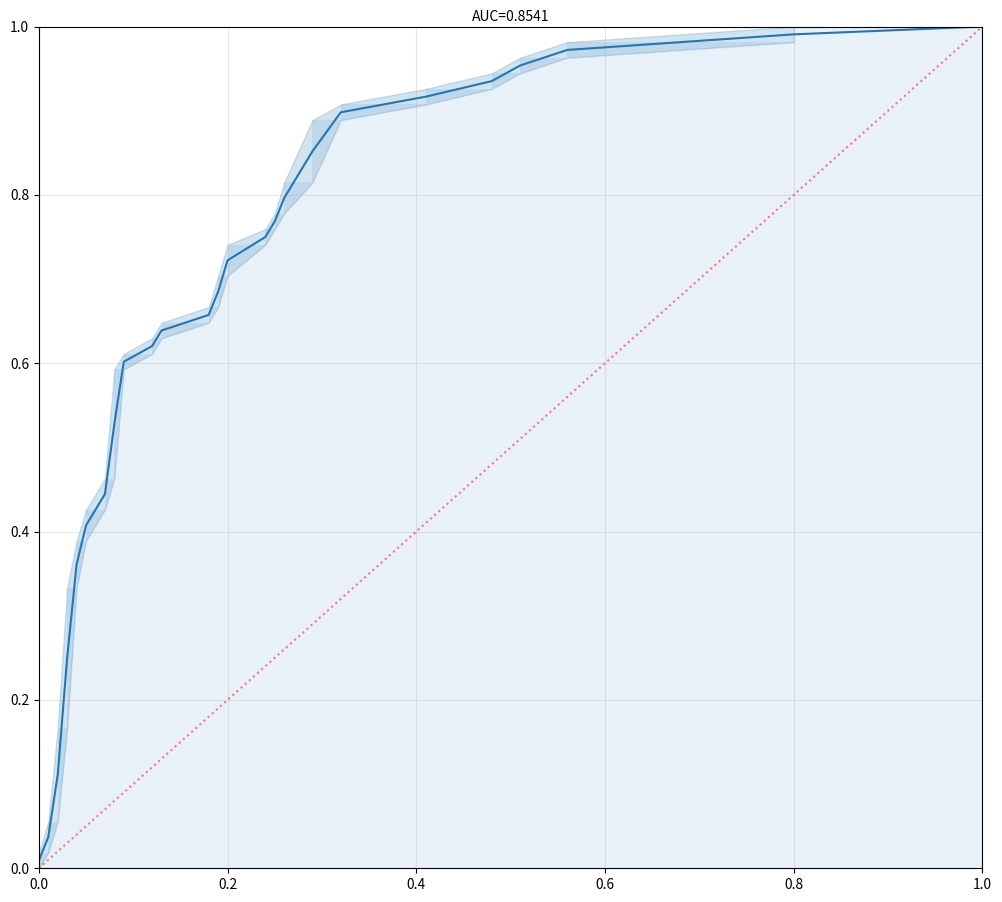

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, tpr)","위양성율(Fallout, fpr)",특이성(TNR),F1 Score,AUC
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854


In [5]:
hs_cls_bin_scores(estimator, x_test, y_test)

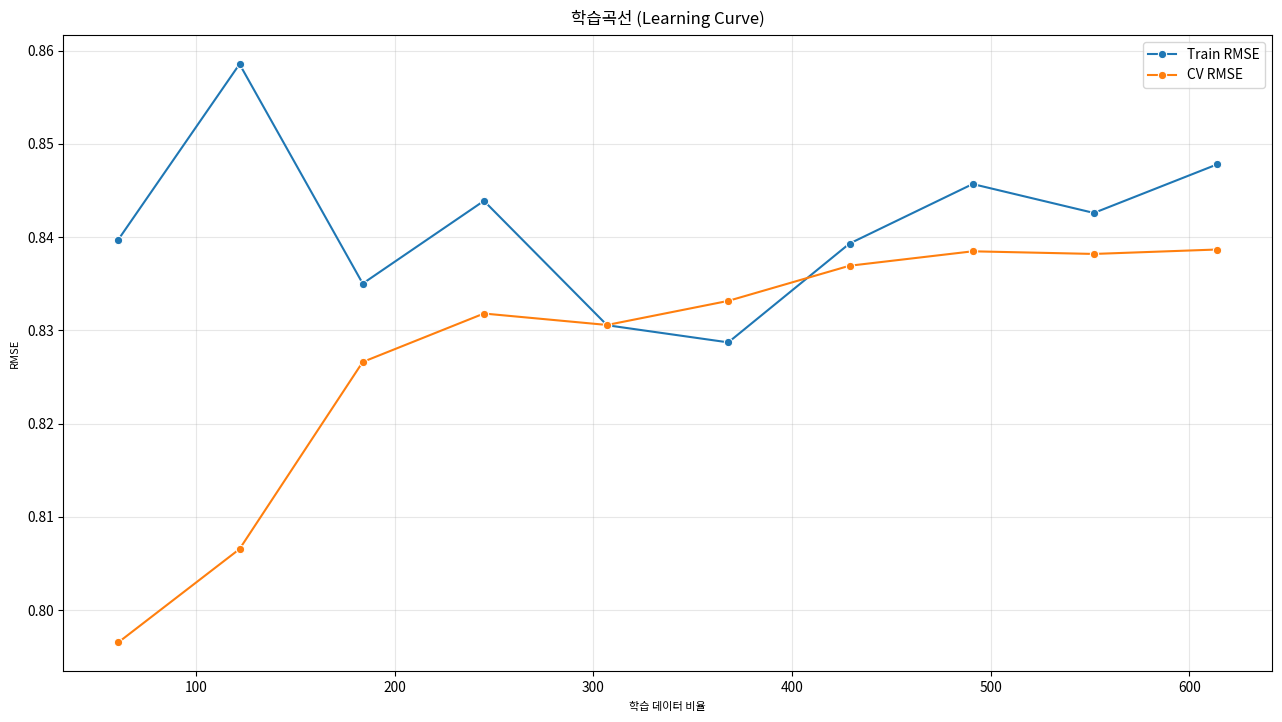

,Train ROC_AUC,CV ROC_AUC 평균,CV ROC_AUC 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
LogisticRegression,0.848,0.839,0.030,0.009,0.030,✅ 일반화 양호


In [6]:
hs_learning_cv(estimator, x, y)